In [1]:
import time
import torch
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit, BlockMABs
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import BlockTrainer as Trainer
from compositional_metarl.trainers import evaluate

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

#  agent behavior @training 

In [2]:
store_path = './store/'

In [3]:
train_protocol='blockMAB'
inputs='context_block_action_reward'
dim_hidden=48
kernel='cosine'
dnd_policy='softmax'
filename=f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}"
blockMABtrainer=np.load(store_path + filename +'.npz')

In [4]:
train_protocol='ControlScheme'
filename=f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}"
controlMABtrainer=np.load(store_path+filename +'.npz')

In [5]:
assert(controlMABtrainer['n_epochs'] == blockMABtrainer['n_epochs'])
n_epochs = controlMABtrainer['n_epochs']

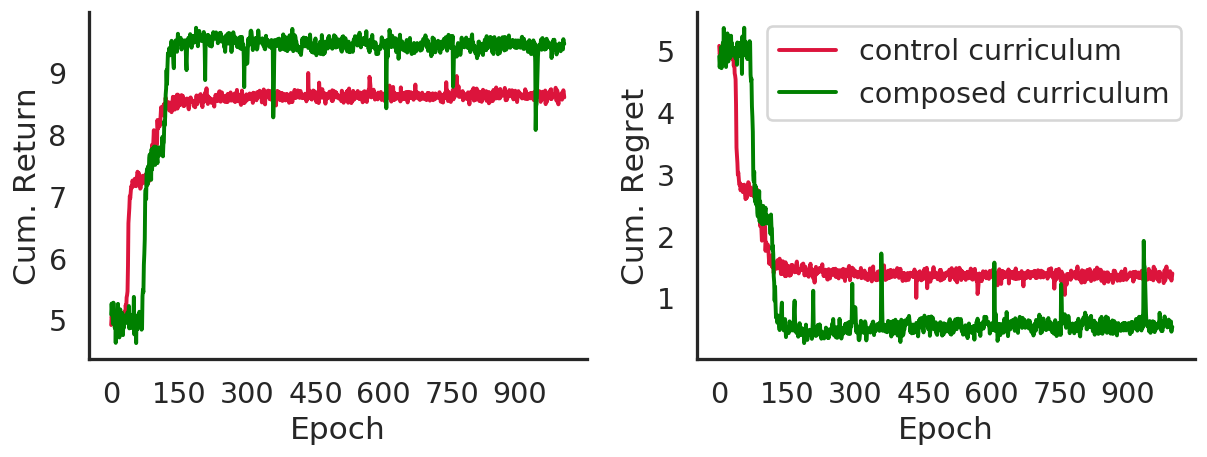

In [6]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=125)
axes[0].plot(controlMABtrainer['log_return'].cumsum(3)[:,:,:,9].mean(2).squeeze()[:n_epochs],'crimson')
axes[0].plot(blockMABtrainer['log_return'].cumsum(3)[:,:,:,9].mean(2).squeeze()[:n_epochs, 2], 'green')
axes[0].set_ylabel('Cum. Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))



axes[1].plot(controlMABtrainer['log_regret'].cumsum(3).max(3).mean(2)[:n_epochs],'crimson')
axes[1].plot(blockMABtrainer['log_regret'].cumsum(3).max(3).mean(2)[:n_epochs, 2], 'green')
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[1].legend(['control curriculum', 'composed curriculum'])
sns.despine()
f.tight_layout()

# agent behavior @test

## load model

In [7]:
'''init model'''
n_arms = 8
dim_hidden = 48 
ctx_dim = 2
inp_dim = None
inputs = 'context_block_action_reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' 
dnd_policy = 'softmax' 
unique_keys = True

In [8]:
train_protocol='ControlScheme'
modelname=f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}"+'.pt'
controlMABagent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
controlMABagent.load_state_dict(torch.load(store_path+modelname))

<All keys matched successfully>

In [9]:
train_protocol='blockMAB'
modelname=f"agent_{train_protocol}_{inputs}_hiddim{dim_hidden}_kernel{kernel}_policy{dnd_policy}"+'.pt'
blockMABagent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, ctx_dim=ctx_dim, inputs=inputs, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
blockMABagent.load_state_dict(torch.load(store_path+modelname))

<All keys matched successfully>

## load task

In [10]:
'''init task'''

start_arm = 0
end_arm = 7
n_arms = (end_arm - start_arm) + 1
n_rounds_per_kernel = 1 # per function
n_blocks = 50
n_trials = 10
composition_block = True
normalize_rewards = True
noise_per_arm = None #'per_arm'
cue_per_epoch = True
CUES =  {'linear': [1., 0.],  'periodic': [0., 1.], 'linperiodic': [1., 1.]}
ctx_dim = len(CUES['linear'])
n_cues = len(CUES)
aoi = {'linear': 7, 'periodic': 1, 'linperiodic': 6}   

In [11]:
bandit = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds_per_kernel, 
                        normalize=normalize_rewards, noise_per_arm=noise_per_arm, cue_per_epoch=cue_per_epoch,
                        best_arms=aoi)
task = BlockMABs(bandit, num_blocks=n_blocks, composition_block=composition_block, num_rounds=n_rounds_per_kernel)

In [12]:
per_trial_performance = {}
per_trial_performance['control_curriculum'] = {}
per_trial_performance['composition_curriculum'] = {}
TRIAL_IDX = 0

In [13]:
all_trial_performance = {}
all_trial_performance['control_curriculum'] = {}
all_trial_performance['composition_curriculum'] = {}

## results for control curriculum

In [14]:
''' model evaluation for different cues'''

block = ['linpos', 'perodd', 'linperiodic'] 
task.evaluate_control()
X, Y, S = task.sample(end_rnd=1, block=block)
n_runs = 10

# create block structure
X, Y, S, _ = task.prepare_data(X, Y, S, block, n_trials)
total_trials =  n_trials if task.eval_control else len(block) * n_trials
init_at = None

In [15]:
from compositional_metarl.model.utils import run_model_eval

In [16]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(controlMABagent, X, Y, S, n_trials, total_trials)

In [17]:
results_dict = {}
results_dict['control_curriculum'] = {'actions':actions, 'rewards': rewards, 'regrets':regrets, 'values':values}

## results for composition curriculum

In [18]:
''' model evaluation for different cues'''

task.evaluate_composition()
X, Y, S = task.sample(end_rnd=1, block=block)

# create block structure
X, Y, S, _ = task.prepare_data(X, Y, S, block, n_trials)
total_trials =  n_trials if task.eval_control else len(block) * n_trials
init_at = None

In [19]:
actions, rewards, values, regrets =  np.zeros((n_runs, total_trials)),  np.zeros((n_runs, total_trials)), np.zeros((n_runs, total_trials, n_arms)),  np.zeros((n_runs, total_trials))

for run_id in range(n_runs):
    actions[run_id], rewards[run_id], regrets[run_id], values[run_id] = run_model_eval(blockMABagent, X, Y, S, n_trials, total_trials)

In [20]:
results_dict['composition_curriculum'] = {'actions':actions, 'rewards': rewards, 'regrets':regrets, 'values':values}

## compare predicted q-values

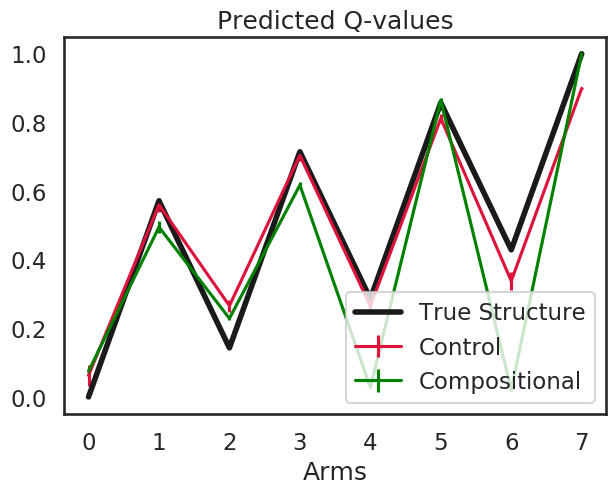

In [21]:
# avg qvalues
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
ax.plot(Y[29].T, 'k', lw=4, label='True Structure')
ax.errorbar(range(n_arms), results_dict['control_curriculum']['values'].mean(1).mean(0), results_dict['control_curriculum']['values'].mean(1).std(0), label='Control', color='crimson')
ax.errorbar(range(n_arms), results_dict['composition_curriculum']['values'][:, 20:].mean(1).mean(0), yerr=results_dict['composition_curriculum']['values'][:, 20:].mean(1).std(0), label='Compositional', color='green')
ax.set_title('Predicted Q-values')
ax.set_xlabel('Arms')
ax.legend(loc='lower right')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## avg return per trial

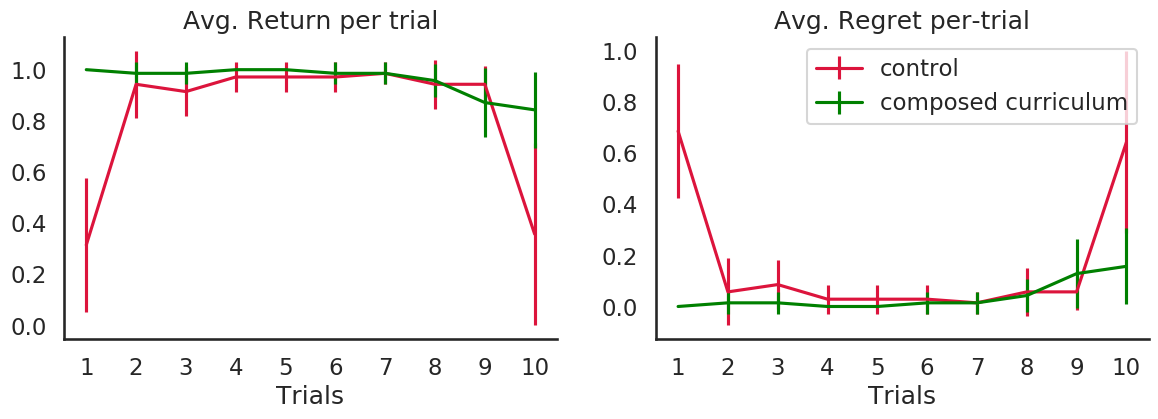

In [22]:
# avg reward across trials
f, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['rewards'].mean(0), yerr= results_dict['control_curriculum']['rewards'].std(0), color='crimson')
ax[0].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['rewards'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['rewards'][:,20:].std(0), color='green')
ax[0].set_title('Avg. Return per trial')
ax[0].set_xlabel('Trials')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

# avg regret across trials
ax[1].errorbar(range(1, n_trials+1), results_dict['control_curriculum']['regrets'].mean(0), yerr=results_dict['control_curriculum']['regrets'].std(0), color='crimson')
ax[1].errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['regrets'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['regrets'][:,20:].std(0), color='green')
ax[1].set_title('Avg. Regret per-trial')
ax[1].set_xlabel('Trials')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend(['control', 'composed curriculum'])
sns.despine()
#f.tight_layout()
plt.show()

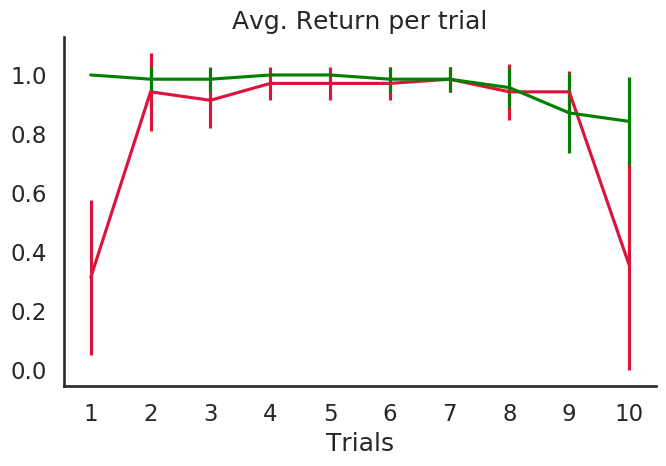

In [23]:
# avg reward across trials
f, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100)
ax.errorbar(range(1, n_trials+1), results_dict['control_curriculum']['rewards'].mean(0), yerr= results_dict['control_curriculum']['rewards'].std(0), color='crimson')
ax.errorbar(range(1, n_trials+1), results_dict['composition_curriculum']['rewards'][:,20:].mean(0), yerr=results_dict['composition_curriculum']['rewards'][:,20:].std(0), color='green')
ax.set_title('Avg. Return per trial')
ax.set_xlabel('Trials')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.despine()
f.tight_layout()
plt.show()

In [24]:
per_trial_performance['control_curriculum']['_'.join(block[:2])] = results_dict['control_curriculum']['rewards'][:, TRIAL_IDX]
per_trial_performance['composition_curriculum']['_'.join(block[:2])] =  results_dict['composition_curriculum']['rewards'][:, TRIAL_IDX+20]

all_trial_performance['control_curriculum']['_'.join(block[:2])] = results_dict['control_curriculum']#['rewards']
all_trial_performance['composition_curriculum']['_'.join(block[:2])] =  results_dict['composition_curriculum']#['rewards']

# compare two curriculums

In [29]:
block = ['linpos', 'perodd']

In [30]:
control = per_trial_performance['control_curriculum']['_'.join(block[:2])]
compositional = per_trial_performance['composition_curriculum']['_'.join(block[:2])]
group_names = ['control', 'compositional']
groups = np.array([control, compositional])
ttest = sp.stats.ttest_ind(groups[0], groups[1])
pval = ttest.pvalue

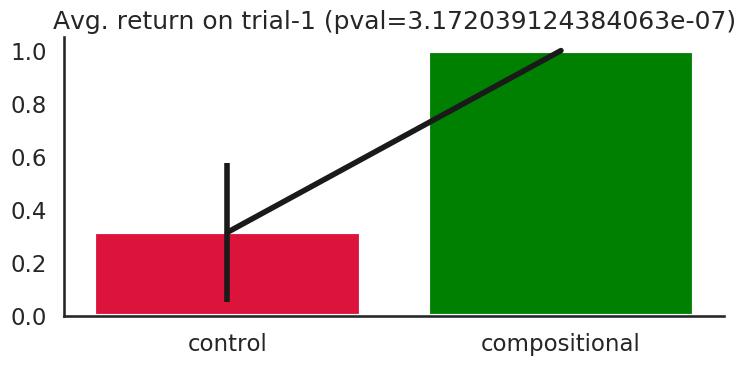

In [31]:
f, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.bar(group_names, groups.mean(1), ecolor='k', linewidth=3, color=['crimson', 'green'])
ax.errorbar(group_names,groups.mean(1), yerr=groups.std(1), color='k', lw=4)
ax.set_title('Avg. return on trial-{} (pval={})'.format(TRIAL_IDX+1, pval))
sns.despine()
f.tight_layout()

## depr

## plots sum across seeds

In [ ]:
load_array = np.load('cache/lp_nseeds5_inpdim2_hiddim32kernel_cosinepolicy_norm_modetraining.npz')

log_Y = load_array['log_Y']
log_Y_hat = load_array['log_Y_hat']
log_return = load_array['log_return']
log_loss_value = load_array['log_loss_value']
log_loss_policy = load_array['log_loss_policy']
n_seeds, n_epochs, n_cues, n_rounds, n_trials = log_Y_hat.shape

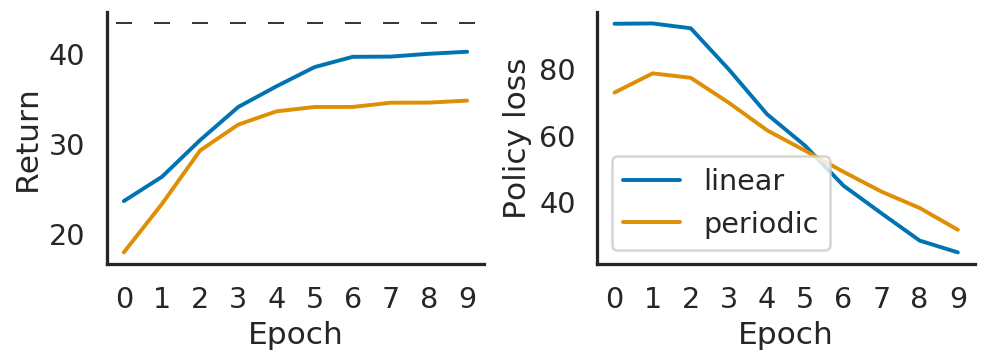

In [187]:
'''learning curve'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_return.mean(0).mean(2))
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].plot(np.repeat(log_Y[:, :, 0, :, 7].mean(0).mean(1).mean(),n_epochs), '_k')

axes[1].plot(log_loss_policy.mean(0).mean(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Policy loss')
axes[1].set_xlabel('Epoch')

# axes[2].plot(log_loss_value.mean(0).mean(2))
# axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[2].set_ylabel('Policy loss')
# axes[2].set_xlabel('Epoch')

plt.legend(CUES)
sns.despine()
f.tight_layout()

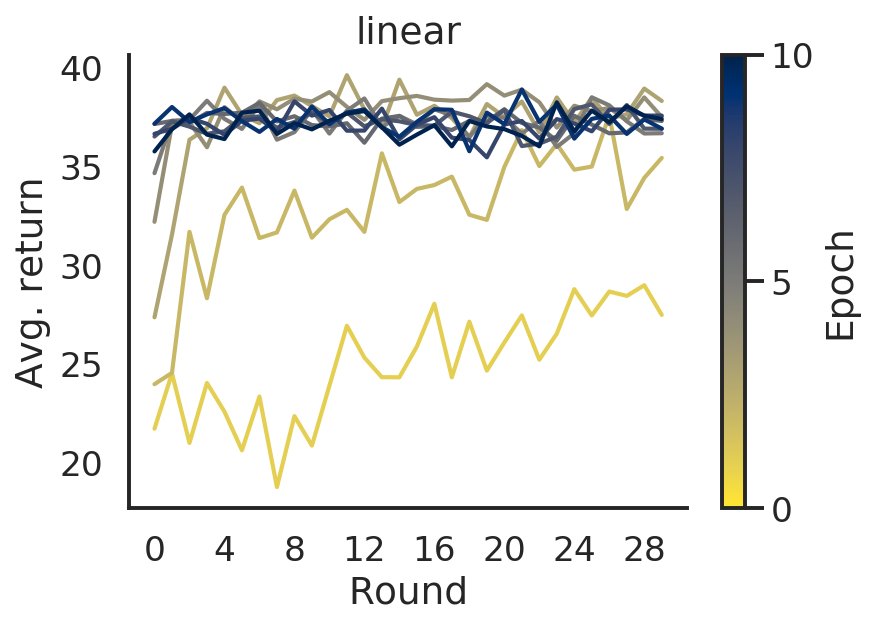

In [173]:
''' average rewards across rounds across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
assert(cue_id is not None)

# set up the color scheme
c = np.arange(n_epochs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# configure figure
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
for ep in range(n_epochs):
    ax.plot(log_return[:, ep, cue_id].mean(0), linewidth=2, c=cmap.to_rgba(ep + 1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Round',
       ylabel='Avg. return',
      title=cue)
cbar = plt.colorbar(cmap, ticks=np.arange(n_epochs+1, step=5), ax=ax)
cbar.set_label('Epoch', rotation=90)
sns.despine()
plt.show()

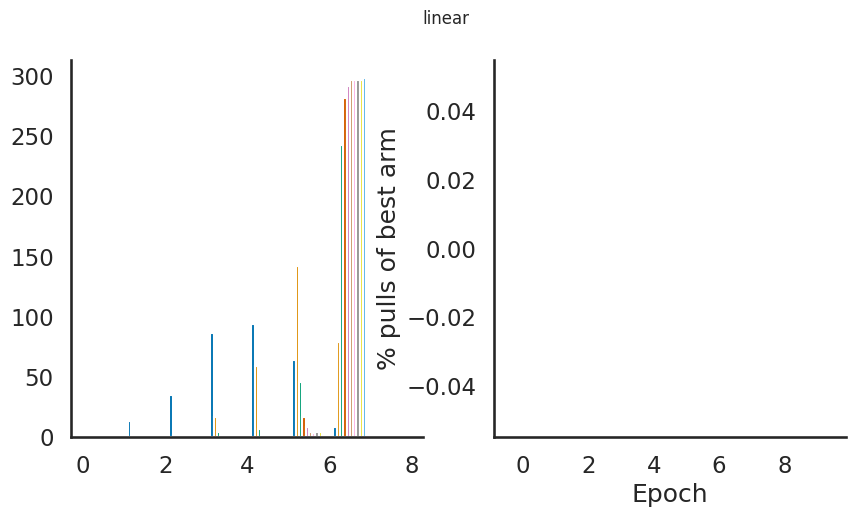

In [175]:
''' action distribution across epochs'''

cue = 'linear'

cue_id = None
for idx, key in enumerate(CUES.keys()):
    if key == cue:
        cue_id = idx
f, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
bins = np.linspace(start_arm, end_arm+1, n_arms+1)
pulls_per_arm = ax[0].hist(log_Y_hat[:, :, cue_id, :, :].mean(0).reshape(n_epochs, n_rounds*n_trials).T, bins=bins)
# ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# ax[0].set(xlabel='Arm', ylabel='No. of pulls per arm')
# ax[0].set_xlim([start_arm, end_arm+1])

ax[1].bar(range(n_epochs), np.vstack(pulls_per_arm[0])[:,aoi[cue]]/(n_rounds*n_trials))
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set(ylabel='% pulls of best arm',
          xlabel='Epoch')
f.suptitle(cue)
sns.despine()

In [159]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel

var = 1 
gamma = 1
res = 100
X = np.linspace(start_arm, end_arm, res).reshape(-1,1)
K = var * rbf_kernel(X, gamma = gamma)
K = var*linear_kernel(X)
mu = np.zeros_like(X).reshape(-1)
samples = np.random.multivariate_normal(mu , K, size=1)

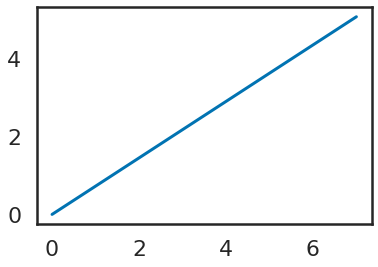

In [160]:
plt.plot(X, samples.T)
plt.show()

In [163]:
# rbf = samples
# add = rbf + samples

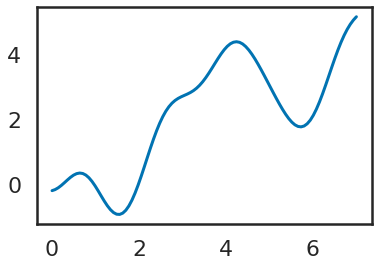

In [164]:
plt.show()

In [199]:
# aa = y[:,0]
# bb = y[:,0]
# cc =torch.cat((aa[0:4], bb[4:]),0)
ddd = np.concatenate(((rbf[-1][:42]+2.1)/3, bb[4:].data.numpy()), 0)
xx = np.concatenate((X.reshape(-1)[:42], np.asarray([4., 5., 6., 7.])), 0)

[Text(0, 0.5, 'Reward'), Text(0.5, 0, 'Arm')]

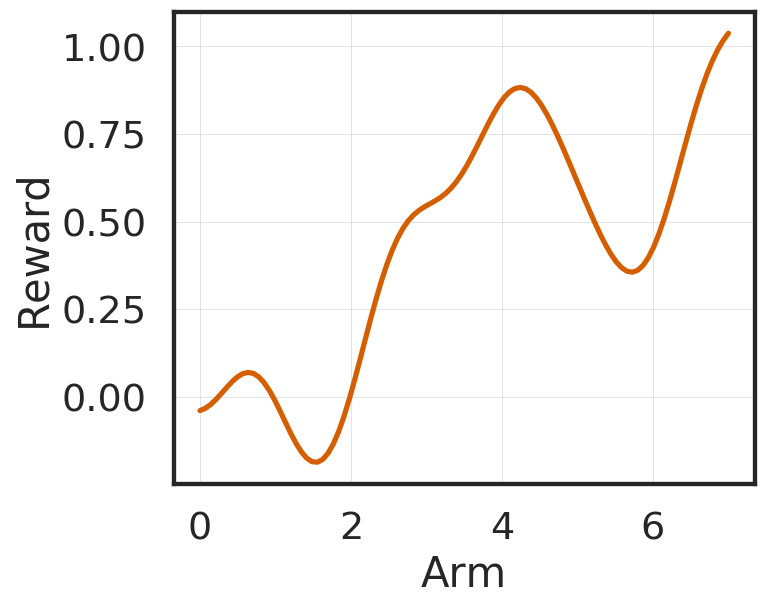

In [203]:

f, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=125)
#ax.plot(xx, ddd, c[idx])
ax.plot(X, addd.T/5.0, c[idx])
#ax.plot(cc.detach().numpy(), c[idx])
ax.grid(lw=0.3)
ax.set(xlabel='Arm', ylabel='Reward')
#a.set(xlabel='Structures')#, ylabel='Mean reward for best arm ')